In [74]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import roc_auc_score, confusion_matrix, log_loss, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, KBinsDiscretizer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from lightgbm import LGBMClassifier
from category_encoders import OneHotEncoder
from sklearn.model_selection import cross_val_predict, RepeatedStratifiedKFold
from warnings import filterwarnings
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn import svm
import os
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import time
from datetime import datetime
filterwarnings('ignore')


In [75]:
# Load data
do_sample = False
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
print("train data shape", train.shape)
print("test data shape", test.shape)


train data shape (250, 302)
test data shape (19750, 301)


In [76]:
train.head(2)

,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,...,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,...,-0.165,-1.695,-1.257,1.359,-0.808,-1.624,-0.458,-1.099,-0.936,0.973


In [77]:
train_input = train.drop(['id','target'],axis = 1)
test_input  = test.drop(['id'],axis = 1)
train_cols = train_input.columns
test_cols = test_input.columns

train_labels = train['target']

#app_train = pd.get_dummies(train_input)
#app_test = pd.get_dummies(test_input)

#imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
#imp_mean.fit(app_train)
#train_imputed = imp_mean.transform(app_train)
#test_imputed = imp_mean.transform(app_test)

scaler = StandardScaler()
scaler.fit(train_input)
train_imputed = scaler.transform(train_input)
test_imputed = scaler.transform(test_input)
train_df = pd.DataFrame(train_imputed, columns = train_cols)
test_df = pd.DataFrame(test_imputed, columns = test_cols)

In [78]:

features = list(train_df.columns)
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
random_forest.fit(train_df,train_labels)
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance':feature_importance_values})


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


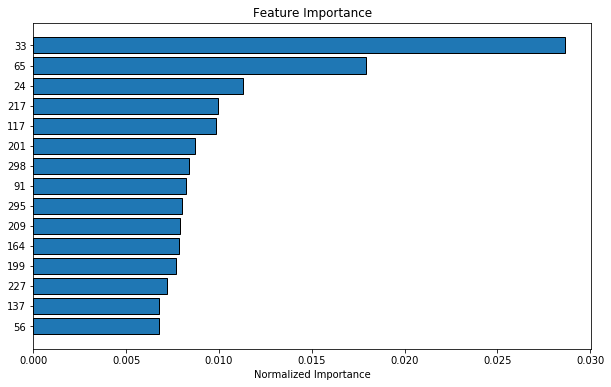

In [79]:
def plot_feature_importances(df):
    #Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    #Normalise the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    
    #Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10,6))
    ax = plt.subplot()
    
    #Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))),
           df['importance_normalized'].head(15),
           align = 'center', edgecolor = 'k')
    #Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    #Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importance')
    plt.show()
    
    return df
feature_importances_sorted = plot_feature_importances(feature_importances)

In [80]:
fe_threshold = 0.001
selected_features = feature_importances_sorted.query('importance_normalized > {}'.format(fe_threshold))['feature'].values
print(selected_features)

['33' '65' '24' '217' '117' '201' '298' '91' '295' '209' '164' '199' '227'
 '137' '56' '268' '214' '43' '144' '80' '189' '266' '139' '48' '230' '111'
 '26' '225' '275' '237' '207' '19' '123' '228' '165' '82' '276' '250'
 '277' '73' '192' '265' '272' '116' '289' '255' '17' '94' '7' '0' '119'
 '156' '12' '131' '285' '169' '147' '242' '247' '16' '170' '149' '240'
 '234' '291' '252' '89' '279' '195' '138' '13' '166' '47' '127' '52' '120'
 '288' '18' '148' '208' '141' '130' '155' '180' '51' '44' '101' '129' '23'
 '113' '37' '150' '132' '173' '202' '76' '239' '58' '163' '257' '215'
 '221' '40' '292' '284' '108' '226' '135' '4' '97' '9' '39' '191' '145'
 '77' '96' '11' '194' '152' '267' '204' '53' '66' '142' '259' '27' '30'
 '160' '231' '270' '98' '248' '42' '8' '278' '110' '185' '114' '256' '153'
 '206' '14' '238' '1' '271' '220' '84' '280' '106' '198' '162' '178' '100'
 '134' '258' '161' '253' '246' '154' '29' '62' '177' '68' '286' '67' '83'
 '200' '236' '78' '122' '118' '21' '171' '151' '1

In [8]:
#target_column ='target'
#id_column = 'id'
#categorical_cols = [c for c in train_input.columns if train_input[c].dtype in [np.object]]
#numerical_cols = [c for c in train_input.columns if train_input[c].dtype in [np.float, np.int] and c not in [target_column, id_column]]
#preprocess = make_column_transformer(
#    (numerical_cols, make_pipeline(SimpleImputer(), StandardScaler())),
#    (categorical_cols, OneHotEncoder()))
#train_input = preprocess.fit_transform(train_input)
#test_input = preprocess.fit_transform(test_input)
#print(type(train_input))

<class 'numpy.ndarray'>


In [81]:
selected_df = pd.DataFrame()
selected_test = pd.DataFrame()
for col in selected_features:
    selected_df[col] = train_df[col]
    selected_test[col] = test_df[col]

In [82]:
def cross_validation(model_, train_, target_):
    
    clfs = []
    folds = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 20, random_state = 42)
    
    valid_pred = pd.DataFrame(index = train_.index)
    
    # Cross-validation cycle
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(target_, target_)):
        print('--- Fold {} started at {}'.format(n_fold, time.ctime()))
        
        train_x, train_y = train_.iloc[train_idx], target_.iloc[train_idx]
        valid_x, valid_y = train_.iloc[valid_idx], target_.iloc[valid_idx]
        
        
        model_.fit(train_x, train_y)
    
        clfs.append(model_)

        predict = model_.predict_proba(valid_x)[:, 1]
    
        tn, fp, fn, tp = confusion_matrix(valid_y, (predict >= .5) * 1).ravel()
        auc = roc_auc_score(valid_y, predict)
        acc = accuracy_score(valid_y, (predict >= .5) * 1)
        loss = log_loss(valid_y, predict)
        print('TN =', tn, 'FN =', fn, 'FP =', fp, 'TP =', tp)
        print('AUC = ', auc, 'Loss =', loss, 'Acc =', acc)
        
        valid_pred[n_fold] = pd.Series(predict, index = valid_x.index)

        del train_x, train_y, valid_x, valid_y, predict
        gc.collect()

    return clfs, valid_pred

In [83]:
classifiers = {
"model_lgbm" : LGBMClassifier(n_jobs=-1,eta=0.01,max_depth=5,max_bin=512,learning_rate=0.01,num_iterations=1000),
"model_xgb" : XGBClassifier(n_jobs=-1, nthreads=-1),
"model_lr" : LogisticRegression(n_jobs=-1, penalty='l1', C=0.2, class_weight='balanced', solver='saga'),
"model_gnb" : GaussianNB(),
"model_rf" : RandomForestClassifier(n_jobs=-1, random_state=42)
}

In [90]:
def get_fitted_models_and_preds(df, labels, models):
    ret =[]
    for k,v in models.items():
        clfs, pred = cross_validation(v, df, labels)
        
        ret.append({'classifier':k, 'score':pred.mean(axis=1), 'preds':pred, 'model': clfs})
        print("model {}: {}".format(k,pred.mean(axis=1)))
    return ret

In [91]:
def predict_models(df, fitted_base_models):
    ret_df = pd.DataFrame()
    for fitted_base_model in fitted_base_models:
        pred = fitted_base_model['model'].predict_proba(df)
        ret_df[fitted_base_model['classifier']] = pred[:,1]
    return ret_df

In [92]:
base_models_preds_train = get_fitted_models_and_preds(selected_df, train_labels, classifiers)

--- Fold 0 started at Fri Apr 19 15:57:52 2019
TN = 8 FN = 7 FP = 10 TP = 25
AUC =  0.7135416666666667 Loss = 0.7130333960270065 Acc = 0.66
--- Fold 1 started at Fri Apr 19 15:57:53 2019
TN = 9 FN = 6 FP = 9 TP = 26
AUC =  0.6996527777777778 Loss = 0.6688204057958184 Acc = 0.7
--- Fold 2 started at Fri Apr 19 15:57:54 2019
TN = 6 FN = 4 FP = 12 TP = 28
AUC =  0.6215277777777777 Loss = 0.8225796916493348 Acc = 0.68
--- Fold 3 started at Fri Apr 19 15:57:54 2019
TN = 6 FN = 2 FP = 12 TP = 30
AUC =  0.8003472222222223 Loss = 0.6455538705979295 Acc = 0.72
--- Fold 4 started at Fri Apr 19 15:57:55 2019
TN = 4 FN = 4 FP = 14 TP = 28
AUC =  0.6892361111111112 Loss = 0.722543360587448 Acc = 0.64
--- Fold 5 started at Fri Apr 19 15:57:55 2019
TN = 4 FN = 3 FP = 14 TP = 29
AUC =  0.7135416666666667 Loss = 0.6617380031970035 Acc = 0.66
--- Fold 6 started at Fri Apr 19 15:57:56 2019
TN = 5 FN = 8 FP = 13 TP = 24
AUC =  0.5625 Loss = 0.9942820625109833 Acc = 0.58
--- Fold 7 started at Fri Apr 19 15

In [93]:
df_base_model_preds_train = pd.DataFrame({base_model_pred_train['classifier']:base_model_pred_train['preds'][:,1] for base_model_pred_train in base_models_preds_train})
print(df_base_model_preds_train.head())
print(df_base_model_preds_train.shape)
print(train_labels.shape)

TypeError: '(slice(None, None, None), 1)' is an invalid key

In [38]:
second_level_classifier_gbm = XGBClassifier(
 #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1)

second_level_model= second_level_classifier_gbm.fit(df_base_model_preds_train, train_labels)


In [39]:
ensemble_preds_train = second_level_model.predict_proba(df_base_model_preds_train)
print(ensemble_preds_train[:,1])
ensemble_preds_score = roc_auc_score(train_labels, ensemble_preds_train[:,1])
print(ensemble_preds_score)


[0.9785459  0.28489077 0.8280892  0.9921725  0.9780226  0.8656173
 0.991702   0.97244287 0.8540545  0.88790506 0.01561387 0.9855117
 0.96044517 0.09835116 0.04482976 0.9986941  0.78654677 0.11878137
 0.9989373  0.9602168  0.8828359  0.9943792  0.02890524 0.7775818
 0.8486121  0.84406835 0.99265903 0.8584219  0.9697389  0.6276887
 0.8958335  0.9089668  0.85556626 0.90608627 0.98733276 0.91215974
 0.8907769  0.9174375  0.11738426 0.7129249  0.99867743 0.9310155
 0.82409084 0.06948008 0.950576   0.97067326 0.9113206  0.9024523
 0.08143407 0.09681522 0.78844583 0.8740805  0.1262717  0.9225068
 0.20662516 0.8679902  0.11574811 0.98271906 0.20938759 0.26373172
 0.8637745  0.7253376  0.52488536 0.04986462 0.08124271 0.9240162
 0.40056917 0.97426003 0.8963074  0.9895862  0.08885325 0.98969495
 0.9881045  0.8962298  0.95176023 0.22181703 0.99066544 0.90206605
 0.13961928 0.8447279  0.9080985  0.15721212 0.2413914  0.94571334
 0.9349292  0.9944595  0.03696557 0.85229814 0.9190432  0.9735454
 0.9

In [43]:
df_test_base_model_preds = predict_models(test_input, base_models_preds_train)
print(df_test_base_model_preds.shape)
df_test_base_model_preds_col_ordered = pd.DataFrame()
for col in df_base_model_preds_train.columns:
    df_test_base_model_preds_col_ordered[col] = df_test_base_model_preds[col]
ensemble_preds_test = second_level_classifier_gbm.predict_proba(df_test_base_model_preds_col_ordered)
print(ensemble_preds_test.shape)

(19750, 5)
(19750, 2)


In [46]:
sub = pd.read_csv("data/sample_submission.csv")
print(ensemble_preds_test.shape)
print(sub.shape)

sub[target_column] = ensemble_preds_test[:,1]
sub.to_csv("results/submit_results.csv", index=False)
print('done')

(19750, 2)
(19750, 2)
done


In [50]:
%%bash
kaggle competitions submit -c dont-overfit-ii -f results/submit_results.csv -m "initial"

Successfully submitted to Don't Overfit! II

100%|██████████| 308k/308k [00:01<00:00, 196kB/s] 
